In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk


from pathlib import Path

csv_file_path = "/workspace/logs/train/runs/HSN/convnext/2025-08-25_080147/raw_out.csv"
df = pd.read_csv(csv_file_path)
df.head()

,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,prob_class_9,...,target_class_11,target_class_12,target_class_13,target_class_14,target_class_15,target_class_16,target_class_17,target_class_18,target_class_19,target_class_20
0,0.001335,0.069824,0.010452,0.019424,0.010132,0.005775,0.068420,0.011963,0.035156,0.001846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001661,0.955078,0.050812,0.008415,0.008675,0.002621,0.023071,0.015305,0.019989,0.003416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000866,0.049957,0.007694,0.014114,0.009377,0.004868,0.058777,0.006168,0.068542,0.001846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001165,0.056854,0.010902,0.019608,0.011200,0.006931,0.075745,0.011963,0.028107,0.001325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.005219,0.334961,0.007786,0.011375,0.017715,0.006851,0.031677,0.018585,0.009087,0.002350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Optional imports (only used if available)
try:
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
        confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score,
        brier_score_loss, log_loss
    )
    SKLEARN_AVAILABLE = True
except Exception as e:
    print("scikit-learn not available; some metrics/plots will be skipped.", e)
    SKLEARN_AVAILABLE = False

In [4]:
prob_cols = [c for c in df.columns if c.startswith("prob_class_")]
target_cols = [c for c in df.columns if c.startswith("target_class_")]
print("Num samples (N):", len(df))
print("Probability columns:", prob_cols)
print("Probs min/max:", float(df[prob_cols].min().min()), float(df[prob_cols].max().max()))
C = len(prob_cols)
print("Detected classes (C):", C)


Num samples (N): 12000
Probability columns: ['prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'prob_class_9', 'prob_class_10', 'prob_class_11', 'prob_class_12', 'prob_class_13', 'prob_class_14', 'prob_class_15', 'prob_class_16', 'prob_class_17', 'prob_class_18', 'prob_class_19', 'prob_class_20']
Probs min/max: 0.00028920174 0.99902344
Detected classes (C): 21


In [5]:
Y_true = df[target_cols].values.astype(int)  # [N, C] in {0,1}
Y_prob = df[prob_cols].values.astype(float)  # [N, C] in [0,1]
# Per-class AUROC & AUPRC
auroc_per_class = []
auprc_per_class = []
prevalence_per_class=[]
for j in range(Y_prob.shape[1]):
    try:
        auroc = roc_auc_score(Y_true[:, j], Y_prob[:, j])
        prevalence_class_i = df[f"target_class_{j}"].mean()
        
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(Y_true[:, j], Y_prob[:, j])
    except Exception:
        auprc = np.nan
    auroc_per_class.append(auroc)
    auprc_per_class.append(auprc)
    prevalence_per_class.append(prevalence_class_i)
 


metrics_df = pd.DataFrame({
    "class": list(range(C)),
    "AUROC": auroc_per_class,
    "AUPRC": auprc_per_class,
    "baseline prevalence":prevalence_per_class,
})
display(metrics_df)

# Macro averages
print("Macro AUROC:", np.nanmean(auroc_per_class))
print("Macro AUPRC:", np.nanmean(auprc_per_class))

,class,AUROC,AUPRC,baseline prevalence
0,0,0.830515,0.444212,0.055917
1,1,0.787113,0.725473,0.223000
2,2,0.782370,0.491295,0.090167
3,3,0.942979,0.648667,0.001833
4,4,0.704474,0.267078,0.061250
5,5,0.852154,0.000561,0.000083
6,6,0.812349,0.367473,0.014583
7,7,0.617848,0.027556,0.002333
8,8,0.870555,0.595313,0.026667
9,9,0.911975,0.507164,0.002250


Macro AUROC: 0.7788678907471445
Macro AUPRC: 0.32581923968399257


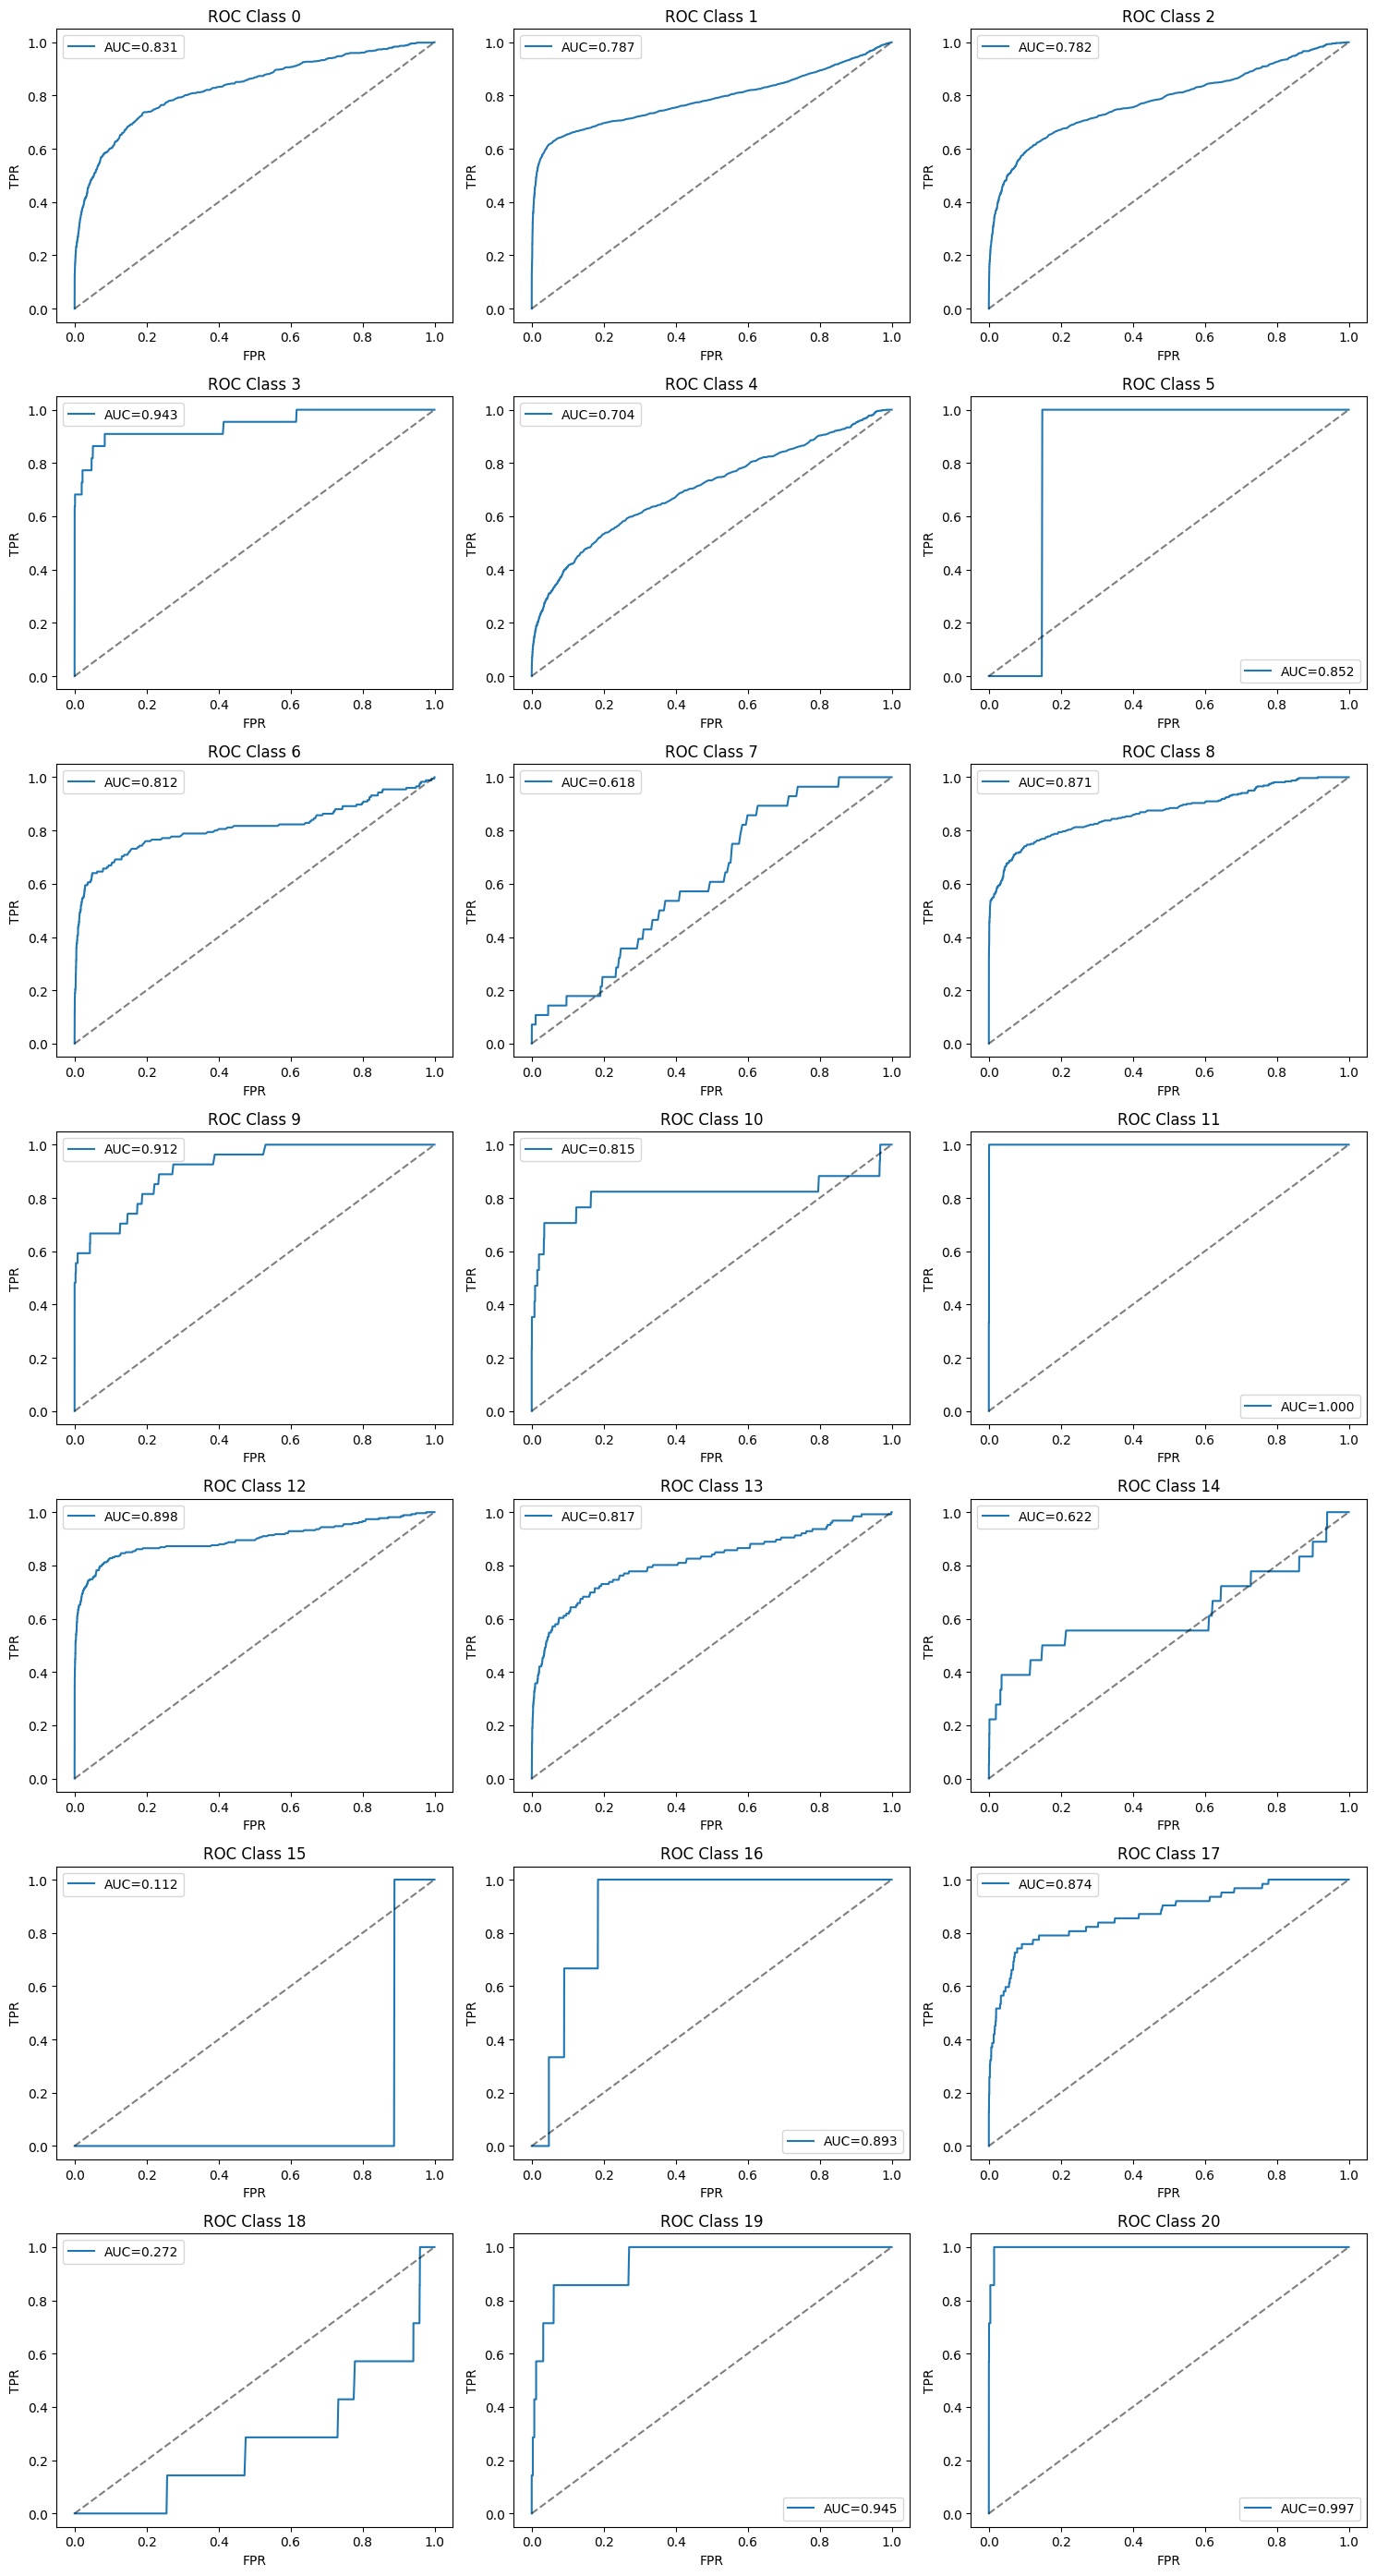

In [6]:
import math

n_classes = Y_prob.shape[1]
cols = 3                               # how many plots per row
rows = math.ceil(n_classes / cols)     # rows needed

# ---------------- ROC curves ----------------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        ax.plot(fpr, tpr, label=f"AUC={auroc_per_class[j]:.3f}")
        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"ROC Class {j}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
    except Exception as e:
        ax.set_title(f"ROC Class {j} (error)")
        print(f"Skipping ROC for class {j}: {e}")

# Hide empty subplots (if n_classes not multiple of cols)
for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


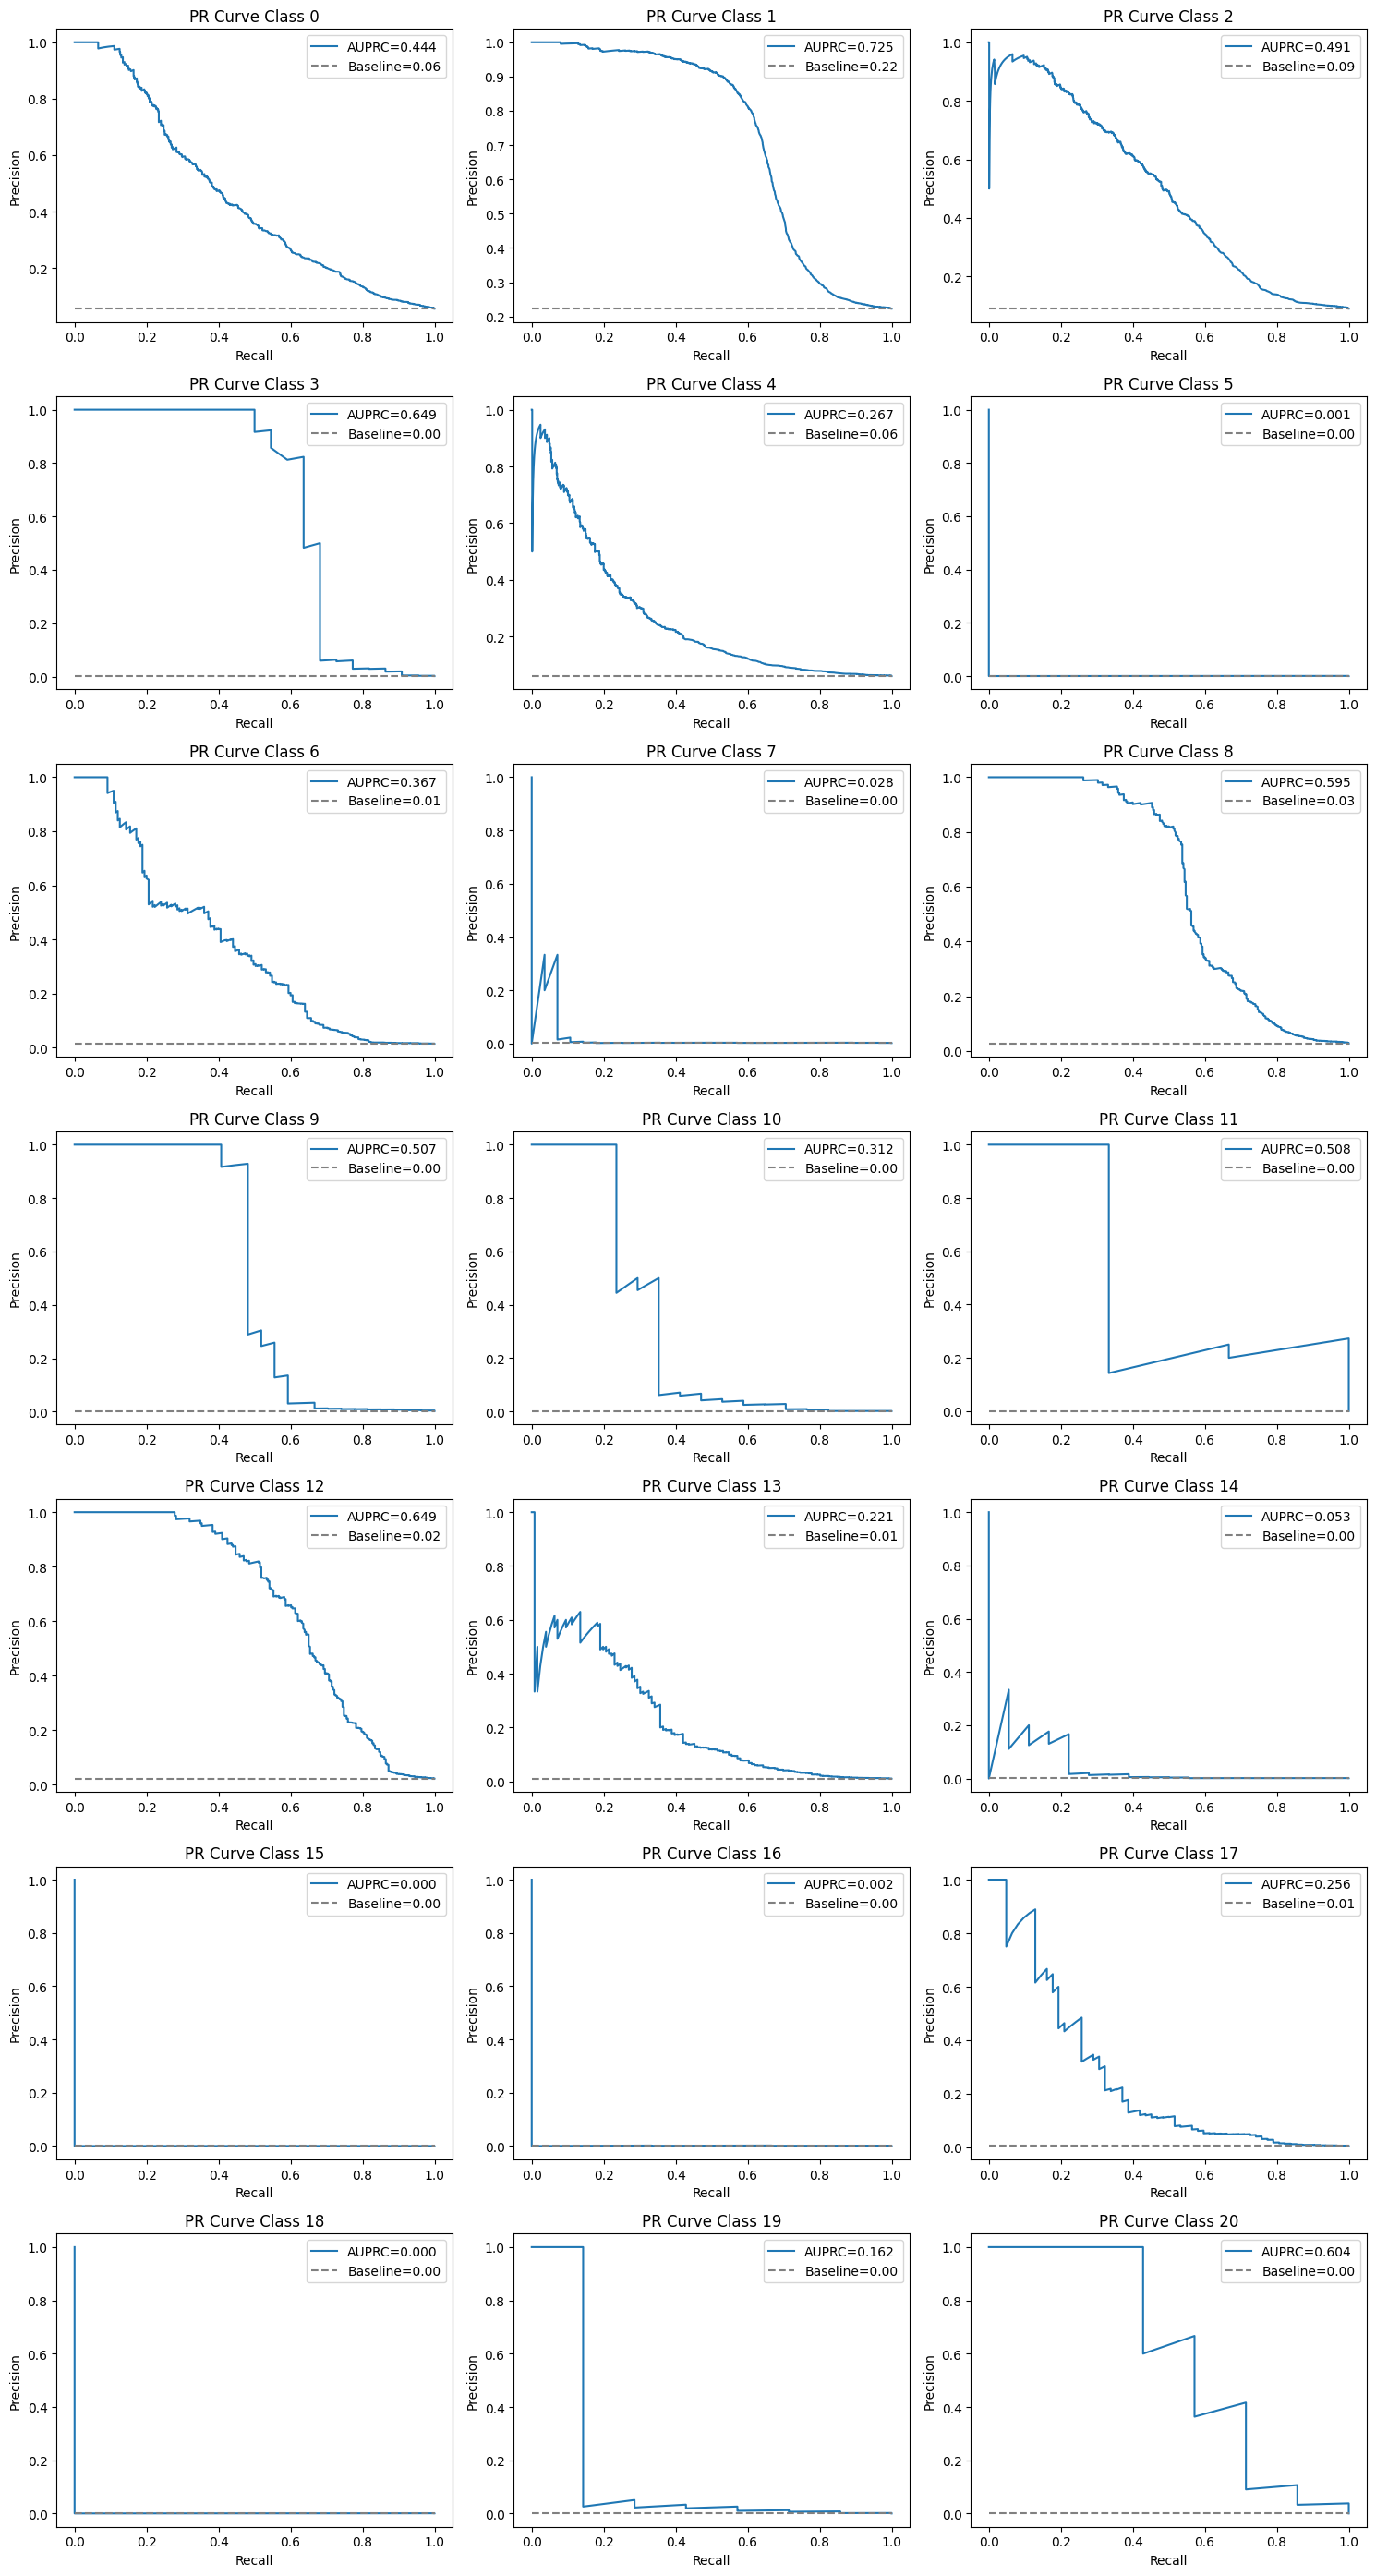

In [7]:
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        precision, recall, _ = precision_recall_curve(Y_true[:, j], Y_prob[:, j])
        baseline = prevalence_per_class[j]
        ax.plot(recall, precision, label=f"AUPRC={auprc_per_class[j]:.3f}")
        ax.hlines(baseline, 0, 1, colors="gray", linestyles="--", label=f"Baseline={baseline:.2f}")
        ax.set_title(f"PR Curve Class {j}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
    except Exception as e:
        ax.set_title(f"PR Class {j} (error)")
        print(f"Skipping PR for class {j}: {e}")

for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

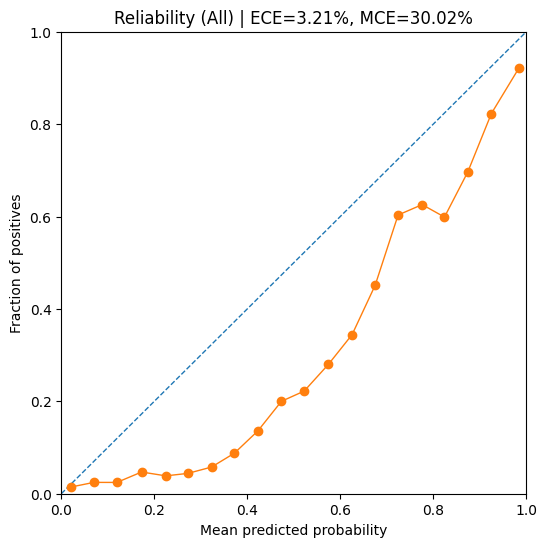

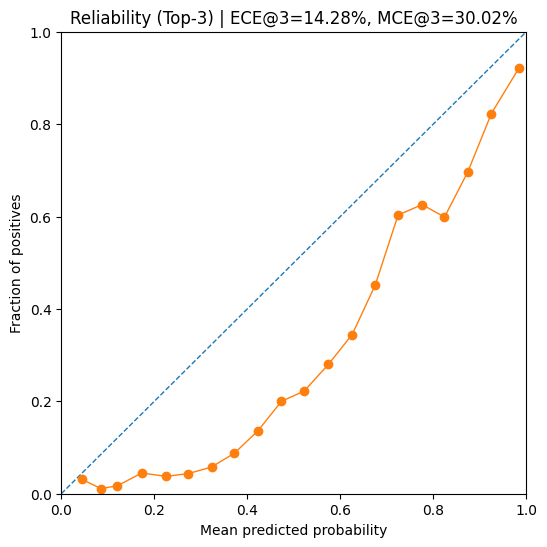

Brier: 0.0247107458108776


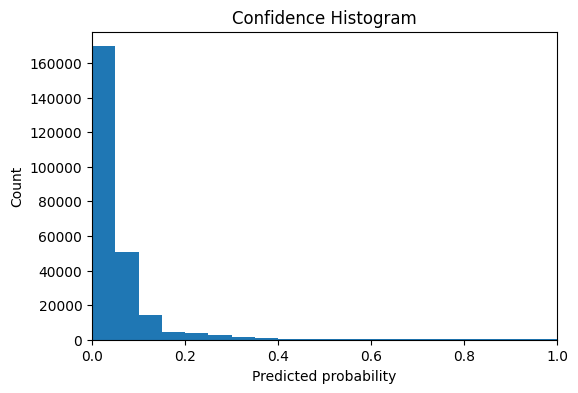

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Extraktion aus DataFrame
# ==============================
def extract_probs_targets(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    prob_cols = [c for c in df.columns if c.startswith(prob_prefix)]
    targ_cols = [c for c in df.columns if c.startswith(target_prefix)]
    if len(prob_cols) == 0 or len(targ_cols) == 0:
        raise ValueError("Keine passenden Spalten gefunden")

    def _suffix_idx(name, prefix): return int(name.replace(prefix, ""))
    prob_cols_sorted = sorted(prob_cols, key=lambda c: _suffix_idx(c, prob_prefix))
    targ_cols_sorted = sorted(targ_cols, key=lambda c: _suffix_idx(c, target_prefix))

    prob_ids = [_suffix_idx(c, prob_prefix) for c in prob_cols_sorted]
    targ_ids = [_suffix_idx(c, target_prefix) for c in targ_cols_sorted]
    if prob_ids != targ_ids:
        raise ValueError("Mismatch zwischen Prob- und Target-Spalten")

    y_prob = df[prob_cols_sorted].to_numpy(dtype=float)
    y_true = df[targ_cols_sorted].to_numpy(dtype=float)
    y_true = (y_true > 0.5).astype(int)
    y_prob = np.clip(y_prob, 0.0, 1.0)
    return y_prob, y_true

# ==============================
# Helfer für Reliability
# ==============================
def _bin_stats(conf, labels, n_bins=10, quantile=False):
    conf = np.asarray(conf).reshape(-1)
    labels = np.asarray(labels).reshape(-1)
    n = conf.size
    if quantile:
        qs = np.linspace(0, 1, n_bins + 1)
        try:
            edges = np.quantile(conf, qs, method="linear")
        except TypeError:
            edges = np.quantile(conf, qs)
        edges[0], edges[-1] = 0.0, 1.0
        edges = np.maximum.accumulate(edges)
    else:
        edges = np.linspace(0, 1, n_bins + 1)

    bin_confs, bin_accs, bin_weights, bin_gaps = [], [], [], []
    for b in range(n_bins):
        left, right = edges[b], edges[b+1]
        if b < n_bins - 1:
            m = (conf >= left) & (conf < right)
        else:
            m = (conf >= left) & (conf <= right)
        if np.any(m):
            c_mean = conf[m].mean()
            a_mean = labels[m].mean()
            w = m.sum() / n
            gap = abs(a_mean - c_mean)
        else:
            c_mean = (left + right) / 2
            a_mean, w, gap = np.nan, 0.0, 0.0
        bin_confs.append(c_mean); bin_accs.append(a_mean)
        bin_weights.append(w); bin_gaps.append(gap)

    bin_confs, bin_accs, bin_weights, bin_gaps = map(np.array, [bin_confs, bin_accs, bin_weights, bin_gaps])
    valid = bin_weights > 0
    ece = float(np.sum(bin_weights[valid] * bin_gaps[valid])) if np.any(valid) else 0.0
    mce = float(np.max(bin_gaps[valid])) if np.any(valid) else 0.0
    return bin_confs, bin_accs, bin_weights, ece, mce

def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true) ** 2))

# ==============================
# Plot Funktionen
# ==============================
def _plot_reliability(bin_confs, bin_accs, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot([0,1],[0,1],"--",linewidth=1)
    mask = ~np.isnan(bin_accs)
    ax.plot(bin_confs[mask], bin_accs[mask], marker="o", linewidth=1)
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(title)
    return ax

def plot_reliability_diagram_all(y_true, y_prob, n_bins=10, quantile=False, ax=None):
    conf, labels = y_prob.reshape(-1), y_true.reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = _bin_stats(conf, labels, n_bins, quantile)
    title = f"Reliability (All) | ECE={ece*100:.2f}%, MCE={mce*100:.2f}%"
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE": ece, "MCE": mce}

def plot_topk_reliability_diagram(y_true, y_prob, k=5, n_bins=10, quantile=False, ax=None):
    N,T = y_true.shape; k = min(k,T)
    idx = np.argpartition(-y_prob, kth=k-1, axis=1)[:, :k]
    rows = np.arange(N)[:,None]
    conf_topk = y_prob[rows, idx].reshape(-1)
    labels_topk = y_true[rows, idx].reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = _bin_stats(conf_topk, labels_topk, n_bins, quantile)
    title = f"Reliability (Top-{k}) | ECE@{k}={ece*100:.2f}%, MCE@{k}={mce*100:.2f}%"
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE@k": ece, "MCE@k": mce}

def plot_confidence_histogram(conf, n_bins=10, ax=None):
    conf = np.asarray(conf).reshape(-1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(conf, bins=n_bins, range=(0,1))
    ax.set_xlim(0,1)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.set_title("Confidence Histogram")
    return ax

# ==============================
#Wrapper für DataFrame
# ==============================
def plot_reliability_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_reliability_diagram_all(y_true, y_prob, n_bins=n_bins, quantile=quantile, ax=ax)

def plot_topk_reliability_from_df(df, k=5, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_topk_reliability_diagram(y_true, y_prob, k=k, n_bins=n_bins, quantile=quantile, ax=ax)

def brier_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return brier_score(y_true, y_prob)





# Klassisches Reliability Diagram
plot_reliability_from_df(df, n_bins=20, quantile=False)
plt.show()

# Top-k Reliability Diagram 
plot_topk_reliability_from_df(df, k=3, n_bins=20, quantile=False)
plt.show()

# Brier Score
print("Brier:", brier_from_df(df))

# Histogramm über alle Wahrscheinlichkeiten
probs = df[[c for c in df.columns if c.startswith("prob_class_")]].to_numpy().ravel()
plot_confidence_histogram(probs, n_bins=20)
plt.show()
